# Лекция 2. Углубление в НС и библиотеку Keras


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

На прошлой лекции мы познакомились с базовым набором инструментов библиотеки Keras, научились строить модели с помощью инструмента ```keras.Sequential()```. Однако на практике не все модели удается реализовать с помощью этого метода.

Если в модели присутствует "нелинейная" структура (т.е. есть разветвление потока данных), то ```keras.Sequential()``` не подойдет для построения такой модели. На помощь приходит инструмент *functional API*.


Рассмотрим следующую модель:

<div class="k-default-codeblock">
```
(input: 784-dimensional vectors)
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
</div>

Обычно в глубоком обучении принято использовать следующую структуру во входных данных:

$$[n, N_{ch}, W,H],$$

где $n$ - размер подвыборки (batch_size), $N_{ch}$ - кол-во каналов (красный, зеленый, синий), $W$, $H$ - ширина и высота изображения. Однако batch_size не указывается при объявлении слоев в Keras. 



In [ ]:
img_inputs = keras.Input(shape=(32, 32, 3))
print(img_inputs.shape)

(None, 32, 32, 3)


На сегодняшний день мы пока забудем о вышеописанной структуре и будем все входные данные трактовать как один длинный вектор длины $(N_{ch}\cdot W \cdot H)$.

In [ ]:
inputs = keras.Input(shape=(784,))

In [ ]:
print("Shape of input is", inputs.shape)
print("Data type of input is", inputs.dtype)

Shape of input is (None, 784)
Data type of input is <dtype: 'float32'>


Следующий слой, который будет использовать тензор `inputs` как входные данные, должен быть объявлен следующим образом:


In [ ]:
x = layers.Dense(32)(inputs) ### объявление слоя
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Activation('relu')(x)
#x = dense1(inputs) ### указание входного тензора

y = layers.Dense(32)(inputs)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Activation('relu')(y)

dense21 = layers.Dense(32, activation="relu")(x)
dense22 = layers.Dense(32, activation='relu')(y)

dense3 = layers.Add()([dense21, dense22])

In [ ]:
x = layers.Dense(32, activation="relu")(dense3)
outputs = layers.Dense(10)(x)

На этом этапе мы можем закончить добавление новых блоков и объявить модель, которая будет состоять из данных слоёв:

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="our_first_model")

In [ ]:
model.summary()

Model: "our_first_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 32)           25120       input_5[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 32)           25120       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         dense_23[0][0]                   
____________________________________________________________________________________

Можно, например, нарисовать модель в виде направленного графа:

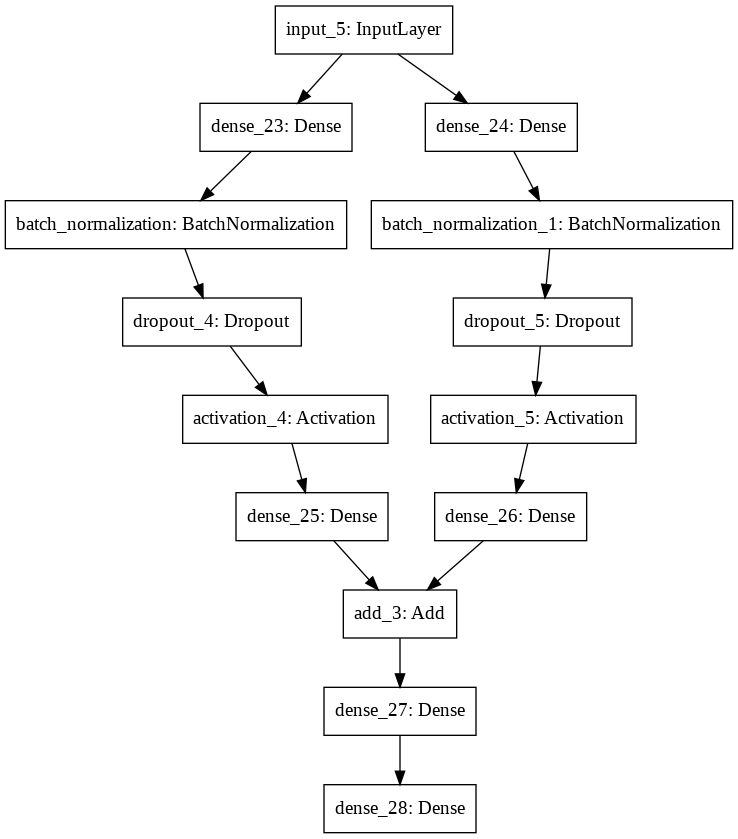

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

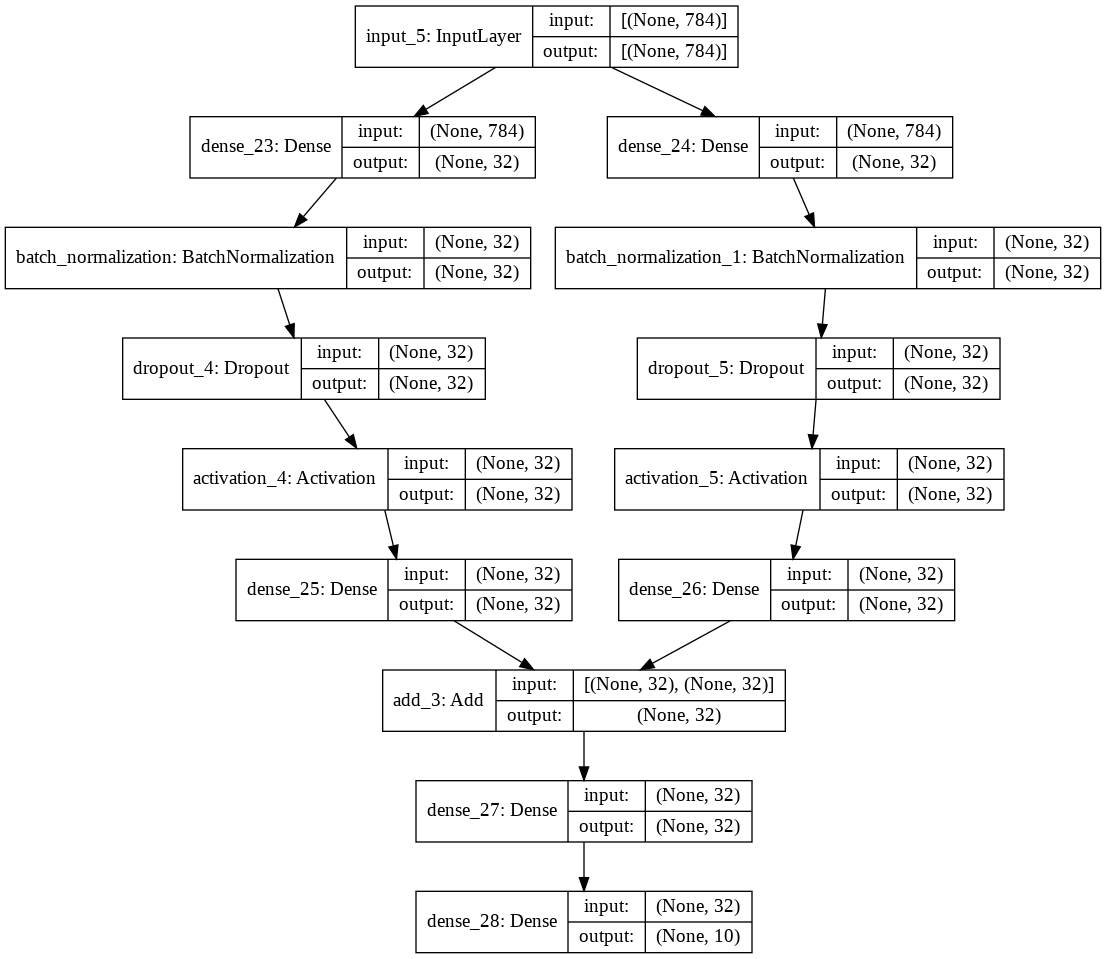

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

## Обучение модели

Обучение модели происходит тем же самым образом, что и модели, объявленной с помощью класса ```Sequential()```, т.е. с помощью метода ```fit()```.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train.reshape(60000, 784).astype("float32") / 255.
x_test = x_test.reshape(10000, 784).astype("float32") / 255.

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), ### ОТЛИЧИЕ_ОТ_CategoricalCrossEntropy
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
750/750 [==============================] - 4s 4ms/step - loss: 0.9907 - accuracy: 0.6868 - val_loss: 0.2356 - val_accuracy: 0.9322
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.4144 - accuracy: 0.8755 - val_loss: 0.2023 - val_accuracy: 0.9409
Epoch 3/10
750/750 [==============================] - 3s 3ms/step - loss: 0.3598 - accuracy: 0.8912 - val_loss: 0.1806 - val_accuracy: 0.9492
Epoch 4/10
750/750 [==============================] - 3s 3ms/step - loss: 0.3427 - accuracy: 0.8974 - val_loss: 0.1740 - val_accuracy: 0.9503
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.3115 - accuracy: 0.9062 - val_loss: 0.1669 - val_accuracy: 0.9527
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2964 - accuracy: 0.9124 - val_loss: 0.1590 - val_accuracy: 0.9541
Epoch 7/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2812 - accuracy: 0.9160 - val_loss: 0.1519 - val_accuracy: 0.9578
Epoch 

## Сохранение модели

 `model.save()` при вызове сохраняет модель в один файл.
Сохраненный файл включает в себя:
- архитектуру модели;
- веса модели;
- config-file (если такой был создан при компиляции);
- оптимизатор и его состояние.

In [ ]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


In [ ]:
model.summary()

Model: "our_first_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 32)           25120       input_5[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 32)           25120       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         dense_23[0][0]                   
____________________________________________________________________________________